# Introduction

This python notebook calculates for a specific receptor point, the concentrations of the air pollutants NO2, PM10 and PM2.5. Calculations are based on Standaardrekenmethode 1 (srm1), which is in the Dutch rule of law the prescribed method for calculating annual averages of atmospheric pollutanys for receptor points that are located in urban areas.   

First, two directories need to be supplied. 
1. dirmod: the directory where the module CARII.py is located (syntax is according to anaconda Jupyter notebook). 
2. dirin: the directory where the input files (gcn large-scale concentration files, meteorological input parameters, and the file with emission factors) are located.

In [1]:
dirmod = 'C:\\Users/ronda002\\CARII\\'
dirin = 'C:/Users/ronda002/CARII/'

The directory in which the CARII module is located needs to be appended to the directories where the jupyter notebook seeks 
for modules.

In [2]:
import sys
sys.path.append(dirmod) # append dirmod to the path where python searches for modules

Importing the module CARII.py. 

In [3]:
import CARII

Importing the modules ipywidgets and pandas. The module ipywidgets is needed to invoke the dropdown menus, and input text boxes for the specifications of the receptor point, and the road segments that contribute to the air pollutant concentration in the receptor points. Pandas is used to load the excel file with the traffic emission factors and handle the emssions factor for use of emission calculations.

In [4]:
import ipywidgets as widgets
import pandas as pd

# Defining the characteristics of the receptor point

Now, we are ready to define a receptor point. In the CARII module, a receptor point is given by a python class with the following attributes:
1. RDW_x: x-coordinates according to the Rijksdriehoekmeting RWD
2. RDW_y: y-coordinates according tot RDW. 
3. year for which the calculations should be done.

Values can be provided using dropdown menu (year) and via input in text boxes (RDW_x and RDW_y).

In [5]:
recep = CARII.receptor()

Dropdown(description='Year', options=(2020, 2025, 2030), value=2020)

BoundedFloatText(value=133382.0, description='RDW-X:', max=280000.0, step=10.0)

BoundedFloatText(value=454361.0, description='RDW-Y:', max=640000.0, min=30000.0)

To calculate the yearly averages of concentrations of air pollutants, Srm1 needs 
- a large-scale (background) concentration for the location of the receptor point. These are derived from the Grootschalige Concentratiekaarten Nederland (GCN), which are generated by the RIVM. In the files provided by the RIVM two values are available: one refers is the GCN concentration at the location of the receptor point, while a second refers to the GCN concentration when all contribution from motorways, Hoofdwegennet (HWN in Dutch, that are located up to a distance of 3.5 km are substracted from the GCN-concentration. GCN maps are provided for horizontal grid boxes of 1 km to 1 km and are available for 2020, 2025 and 2030.
- emission factors for different kinds of vehicles and traffic fluidity types. 
- a 'regio factor', which is calculated as 5/ws, where ws is the ten-year average of the wind speed at the location of the receptor point. 

In [6]:
def calc_gcn_meteo_emissfacts(recep,dirin):
    gcn_bg = {}

# find the gcn large-scale concentrations nad the gcn concentrations where the contribution of the closest motorways 
#is substracted from the large scale concentration.

    for species in ['NOx','NO2','O3','PM10','PM25']:
            gcn,gcn_rwc = CARII.read_gcn(species,str(recep.year.value),recep.RDW_x.value,recep.RDW_y.value,dirin)
            gcn_bg.update({species+'_HWN':gcn})
            gcn_bg.update({species+'_noHWN':gcn_rwc})
    recep.gcn = gcn_bg 
#
# find the local ten-year average wind speed
#
    recep.ws = CARII.read_meteo(recep.RDW_x.value,recep.RDW_y.value,dirin) 
#    
# load the file with emission factors
#
    recep.fact_emiss = pd.read_excel(dirin+'/Emissiefactoren_2020_v12mrt.xlsx',sheet_name='tabel_alle_stoffen_en_jaren',header=0,index_col=[0,5,6])

#
# select only the emission factor for the year given above
#
    recep.fact_emiss_jaar = recep.fact_emiss[recep.fact_emiss['Jaar'] == recep.year.value]
#
# determine the regio factor based on the ten-year average wind speed
#
    recep.Fregio = 5./recep.ws
     

Using the function given in the previous cell, we can calculate for the receptor point defined above the GCN concentrations (both with HWN and without HWN),  wind speed, and the regio factor which are calculated from the ten-year average wind speed. To get acquanted with the output, the variables are printed out.

In [8]:
# fun the function as given above)
calc_gcn_meteo_emissfacts(recep,dirin)

#
# print out the different attributes of the receptor point.
#

for species in ['NOx','NO2','PM10','PM25']:
   print('The GCN concentration for '+species+' including motorways is: ',str(recep.gcn[species+'_HWN'])+' \u03BCg/m3')
   print('The GCN concentration for '+species+' without motorways is: ',str(recep.gcn[species+'_noHWN'])+' \u03BCg/m3')
print('The wind speed is: '+str(recep.ws)+' m/s')
print('Fregio is: '+str(recep.Fregio)+' s/m')

The GCN concentration for NOx including motorways is:  46.41 μg/m3
The GCN concentration for NOx without motorways is:  24.929999999999996 μg/m3
The GCN concentration for NO2 including motorways is:  31.21 μg/m3
The GCN concentration for NO2 without motorways is:  19.020000000000003 μg/m3
The GCN concentration for PM10 including motorways is:  19.08 μg/m3
The GCN concentration for PM10 without motorways is:  18.043 μg/m3
The GCN concentration for PM25 including motorways is:  11.67 μg/m3
The GCN concentration for PM25 without motorways is:  11.2789 μg/m3
The wind speed is: 4.06 m/s
Fregio is: 1.2315270935960592 s/m


# Defining road segment(s)

Yearly averaged concentrations at a receptor point are the sum of the large-scale (GCN) concentrations (with or without HWN), and a contribution from the emissions by local traffic. To calculate the contribution of a local trffic emissions, parameter values need to be provided for the road segments (rijbanen in Dutch). Usually, a road segment consist of only one road part (rijbaan). Traffic moving either way is thereby considered to move on a single road track. However, occasionally, roads are divided into separate lanes that should be considered as two road parts. In these cases. parameters can be supplied for a number of road part.  
For each road part the following information need to be provided:
1. Srmqwegtype:  this parameter can be either 'motorway' or 'non-motorway'. For srm1, only non-motorways can be considered.

2. Verkeerstype: the fluidity type of the of the traffic. There are three cateogories: 
    - c: normaal stadsverkeer (ENG: normal urban traffic)
    - d: stagnerend stadsverkeer (ENG: urbn traffic with stagnation)
    - e: stadsverkeer met minder congestie (ENG: urban traffic with less stagnation).

    The letters c, d and e refer to the previous traffic fluidity types that were defined for the orginal CAR-II model. For the main roads within an urban environment they are defined the NSL monitoring tool using the letter identifiers as given above. 
3. FS: the fraction of daily traffic that should be considered as congested traffic. 
4. LWV: the number of light weight vehicles per day
5. MWV: the number of medium-weight vehicles per day, 
6. HWV: the number if heavy-weight vehicles perd day,
7. buses: the number of buses per day, 
8. wegtype: the type of the road. Four types are defined (see figure below for a definition).

<img src="wegtype.png">

9. tree factor 
    - 1: no trees
    - 1.25: seperate trees
    - 1.5: trees that have overlapping crowns
    (see figure below for graphical description of the tree factor that needs to be given).
<img src="treefraction.png">
10. Distance: distance between the center line of the road part and the receptor point.

In [9]:
recep.define_rijbanen()

Dropdown(description='Nr road parts', options=(1, 2), value=1)

Give parameters for road section:  1


Dropdown(description='Srmwegtype', options=('non-motorway', 'motorway'), value='non-motorway')

Dropdown(description='Verkeerstype', options=('stad normaal', 'stad doorstromend', 'buitenweg'), value='stad n…

BoundedFloatText(value=0.0, description='FS:', max=1.0, step=0.01)

BoundedFloatText(value=6800.0, description='LWV:', max=100000000.0, step=100.0)

BoundedFloatText(value=165.0, description='MWV:', max=100000000.0, step=100.0)

BoundedFloatText(value=65.0, description='HWV:', max=100000000.0, step=100.0)

BoundedFloatText(value=0.0, description='Buses:', max=100000000.0, step=100.0)

Dropdown(description='Wegtype', options=('1', '2', '3', '4'), value='1')

Dropdown(description='Tree factor', options=(1.0, 1.25, 1.5), value=1.0)

FloatText(value=13.0, description='Distance')

Now that we have defined the characteristics of the road (parts) that contribute  to the 
Below a function is given that calculates for all road parts that contribute to the concentration at a certain receptor point, the emissions. Emissions depend on: 
1. Verkeerstype: the fluidity type of the of the traffic. There are three cateogories (see above):
2. FS: the fraction of daily traffic that should be considered as congested traffic.
3. LWV: the number of light weight vehicles per day
4. MWV: the number of medium-weight vehicles per day,
5. HWV: the number if heavy-weight vehicles perd day,
6. buses: the number of buses per day.

Emissionfactors are calculated from the pandas dataframe f_jaar, which give emission factors for different species depending on the type of the vehicles (Light weight, medium-heave weigth etc.) and the traffic fluidity type.

In [10]:
def calc_Emiss(recep):
    
    f_jaar = recep.fact_emiss_jaar 
    

# depending on the srmwegtype, emissionfactors for motorways or non-motorways are selected
#
    for rijbaan in recep.rijbanen:
        if rijbaan.Srmwegtype.value == 'non-motorway':
            f_all = f_jaar['Waarde'][f_jaar['Srmwegtype'] == 'niet-snelweg']
        elif rijbaan.Srmwegtype.value == 'motorway':
            print('Motorway not implemented yet')
            print('Switched to non-motorway')
            f_all = f_jaar['Waarde'][f_jaar['Srmwegtype'] == 'niet-snelweg']         
        else:
            print('Illegal Srmwegtype')

#
# here some copying is done, from rood_part characteristics to local varaiables.
#

        FS = rijbaan.FS.value
        LWV = rijbaan.LWV.value
        MWV = rijbaan.MWV.value
        HWV = rijbaan.HWV.value
        buses = rijbaan.buses.value
        verkeer = rijbaan.verkeer.value

#
# calculate the emissions
#
        
        E = {}
        for species in ['NOx','NO2','PM10totaal','PM2.5totaal']:
            E_LWV = (1.-FS)*LWV*f_all.loc['Licht wegverkeer',verkeer,species]+FS*LWV*f_all.loc['Licht wegverkeer','file',species]
            E_MWV = (1.-FS)*MWV*f_all.loc['Middelzwaar wegverkeer',verkeer,species]+FS*MWV*f_all.loc['Middelzwaar wegverkeer','file',species]
            E_HWV = (1.-FS)*HWV*f_all.loc['Zwaar wegverkeer',verkeer,species]+ FS*HWV*f_all.loc['Zwaar wegverkeer','file',species]         
            E_bus = (1.-FS)*buses*f_all.loc['Bussen',verkeer,species]+FS*buses*f_all.loc['Bussen','file',species]              
            E[species] = (E_LWV+E_MWV+E_HWV+E_bus)*1000./(24.*3600.)
        E['PM10'] = E['PM10totaal']
        E['PM25'] = E['PM2.5totaal']
        del(E['PM10totaal'])
        del(E['PM2.5totaal'])
        rijbaan.emiss = E

Using the function given in the previous cell, we can calculate for the different road parts defined above the emissions for NOx, NO2, PM10 and PM2.5. To get acquainted with the output, print outs are made of all emissions form all defined road parts.

In [11]:
calc_Emiss(recep)
for id,rijbaan in enumerate(recep.rijbanen):
    for species in ['NOx','NO2','PM10','PM25']:
        print('The emission of '+species+' for road segement '+str(id+1)+' is: '+str(rijbaan.emiss[species])+' \u03BCg/m/s')
    

The emission of NOx for road segement 1 is: 40.9183912037037 μg/m/s
The emission of NO2 for road segement 1 is: 6.8111400462962965 μg/m/s
The emission of PM10 for road segement 1 is: 2.9389756944444443 μg/m/s
The emission of PM25 for road segement 1 is: 0.9619849537037037 μg/m/s


In the GCN large-scale concentrations are given with and without the motorways. If large scale concentrations are sued witout
the motorways, the contribution of all roads that are calculated according to standaardrekenmethode 2 need to be calculated.
However, contributions by Srm2 roads can also be prescribed by the user. Contributions need to be provided fo NOx, PM10 and PM2.5, while also a value of the fraction of direct emissions of NO2 over all NOx emissions for Srm2 roads need be to given.

In [12]:
recep.get_srm2()

BoundedFloatText(value=0.199, description='FNO2_srm2:', max=1.0, step=0.01)

BoundedFloatText(value=1.776, description='Conc NOx SRM2:')

BoundedFloatText(value=0.095875, description='Conc PM10 SRM2:')

BoundedFloatText(value=0.04, description='Conc PM2.5 SRM2:')

Now that we have the emissions of the different road parts for the different species, the contribution to NO2, PM10, PM2.5 of Srm2 road, and the fractio of direct emissions of NO2 over all emission of NOx for Srm2 roads, we can calculate the contribution of traffic on the concentration of the different species and the total concentrations. 

In [13]:
def calc_concs(recep):

#
# determining the parameters of all road types for calcultion the dispersion factor
#
    param_dict = {'1':{'a':3.25E-5,'b':-2.05E-2,'c':0.39,'alpha':0.856},'2':{'a':4.88E-4,'b':-3.08E-2,'c':0.59},
              '3':{'a':5.00E-4,'b':-3.16E-2,'c':0.57},'4':{'a':3.1E-4,'b':-1.82E-2,'c':0.33,'alpha':0.799}}



#
# sum the contributions of all read parts
# 
    conc_NO2_dir = 0.
    conc_tot_NO = 0.
    conc_tot_pm10 = 0.
    conc_tot_pm25 = 0.

#
# perform the calculations for all read parts and sum them up
# 

    for rijbaan in recep.rijbanen:      

#
# first, calculate for the road part under scop the disperion factor 
# the dispersion factor is a function of distance of the center line of the road part to the receptor point
# and the functional form depends on the distance
#
        
        if 3.5 <= rijbaan.dist.value <= 30.:
              theta = param_dict[rijbaan.wegtype.value]['a']*rijbaan.dist.value**2.+param_dict[rijbaan.wegtype.value]['b']*rijbaan.dist.value +param_dict[rijbaan.wegtype.value]['c']
        else:
            try:
                theta = param_dict[rijbaan.wegtype.value]['alpha']*rijbaan.dist.value**(-.747)
            except:
                print('theta not defined for wegtype: ',rijbaan.wegtype.value)

#
# calculation the contribution of the road part under scope to NOx
#
        conc_NOx = .62*rijbaan.emiss['NOx']*theta*rijbaan.boomfrac.value*recep.Fregio

#    
# calculate the contribution to NO2 by direct emissions of NO2 and add it to the total concentration
#
        conc_NO2_dir += rijbaan.emiss['NO2']/rijbaan.emiss['NOx']*conc_NOx

#
# calculate the contribution to NO by the road part under scope and add it to the total contribution
#
        conc_tot_NO += (1.-rijbaan.emiss['NO2']/rijbaan.emiss['NOx'])*conc_NOx

#
# calculate the contribution to PM10 by the road part under scope and add it to the total contribution
#
    
    
        conc_pm10 = .62*rijbaan.emiss['PM10']*theta*rijbaan.boomfrac.value*recep.Fregio
        conc_tot_pm10 += conc_pm10

#
# calculate the contribution to PM2.5 by the road part under scope and add it to the total contribution
#
        
        conc_pm25 = .62*rijbaan.emiss['PM25']*theta*rijbaan.boomfrac.value*recep.Fregio
        conc_tot_pm25 += conc_pm25
        
#
# make the the contribution of traffic by Srm2 road as an attribute of the receptor point
#

    recep.Cb = {}
    recep.Cb['NO2-dir_srm1'] = conc_NO2_dir # NO2 contributions of direct emissions of NO2 on Srm1 roads
    recep.Cb['NO_srm1'] = conc_tot_NO # NO contribution of Srm1 roads
    recep.Cb['NOx_srm1'] = conc_NO2_dir+conc_tot_NO # NOx contribution of Srm1 roads
    recep.Cb['PM10_srm1'] = conc_tot_pm10 # PM10 contribution of Srm1 roads
    recep.Cb['PM2.5_srm1'] = conc_tot_pm25 #PM2.5 contribution of Srm1 roads
    
    recep.Cb['NOx_srm2'] = recep.conc_NOx_srm2.value # NOx contribution of Srm2 roads
    recep.Cb['FNO2_srm2'] = recep.FNO2_srm2.value # fraction of NO2 emissions over NOx emissions
    recep.Cb['PM10_srm2'] = recep.conc_PM10_srm2.value # PM10 contribution of Srm2 roads
    recep.Cb['PM2.5_srm2'] = recep.conc_PM25_srm2.value # PM2.5 contribution of Srm2 roads
    
    conc_NO2_dir += recep.FNO2_srm2.value*recep.conc_NOx_srm2.value # total traffic contribution of Srm1 and Srm2 roads
    conc_srm2_NO = (1.-recep.FNO2_srm2.value)*recep.conc_NOx_srm2.value # total NO contribution of Srm1 and Srm2 roads

#    
# psrt of the NO emitted by the traffic reacts with ozone, thus augmenting the concentrations of NO2 
# 

    # calculate the equivalent contribution of NO because of traffic on Srm2 roads
    
    eps = conc_srm2_NO/(conc_srm2_NO+100.)*(1./.6)
    conc_NO_srm2_eq = eps/(1.-eps)*100.
    
    # add the equivalent contribution of NO because of traffic on Srm2 roads to the total NO contribution
    
    conc_tot_NO += conc_NO_srm2_eq

#
# calculation of the total contrition of traffic on Srm2 and Srm1 road on NO2
# it is calculated as the sum of the contribution of traffic because of direct emissions of NO2
# and a contribution to NO2 because part of the NO reacts with ozone to form NO2
#
    conc_tot_NO2 = conc_NO2_dir+.6*recep.gcn['O3_HWN']*conc_tot_NO/(conc_tot_NO+100.)

#
# make the the contribution of traffic by Srm1 and Srm2 road an attribute of the receptor point
#
    recep.Cb['NO-tot'] = recep.Cb['NO_srm1'] +conc_srm2_NO  # NO contribution
    recep.Cb['NOx'] = recep.Cb['NOx_srm1']+recep.conc_NOx_srm2.value # NOx contribution
    recep.Cb['NO2'] = conc_tot_NO2 # NO2 contribution
    recep.Cb['PM10'] = conc_tot_pm10+recep.conc_PM10_srm2.value # PM10 contrubution
    recep.Cb['PM2.5'] = conc_tot_pm25+recep.conc_PM25_srm2.value # PM2.5 contribution

#
# calculate the total conetrations make them attributes of the receptor point
#
    recep.Ctot = {}
    recep.Ctot['NO2'] = recep.gcn['NO2_noHWN']+recep.Cb['NO2']
    recep.Ctot['PM10'] = recep.gcn['PM10_noHWN']+recep.Cb['PM10']
    recep.Ctot['PM2.5'] = recep.gcn['PM25_noHWN']+recep.Cb['PM2.5'] 

Run the function as given above for the receptor point and print out the results

In [14]:
calc_concs(recep)
print('The NOx contribution of NOx emissions of SRm1 reads is: ',str(recep.Cb['NOx_srm1']))
print('The PM10 contribution of PM10 emissions of SRm1 reads: ',str(recep.Cb['PM10_srm1']))    
print('The NO2 contribution of direct NO2 emissions of SRm1 roads is: ',str(recep.Cb['NO2-dir_srm1']))
print('The NOx contribution of NOx emission of SRM2 roads is: '+str(recep.Cb['NOx_srm2']))
print('The PM10 contribution of PM10 emissions of SRM2 road is: '+str(recep.Cb['PM10_srm2']))
print('The PM10 contribution of PM2.5 emissions of SRM2 road is: '+str(recep.Cb['PM2.5_srm2']))
print('The total contribution of road emissions to NOx concentration is: '+str(recep.Cb['NOx']))
print('The total contribution of road emissions to PM10 concentration is: '+str(recep.Cb['PM10']))
print('The total contribution of road emissions to PM2.5 concentration is: '+str(recep.Cb['PM2.5']))
print('The total contribution of road emissions to NO2 concentration is: '+str(recep.Cb['NO2']))
print('The total concentration of NO2 at the receptor point is: '+str(recep.Ctot['NO2']))
print('The total concentration of PM10 at the receptor point is: '+str(recep.Ctot['PM10']))
print('The total concentration of PM2.5 at the receptor point is: '+str(recep.Ctot['PM2.5']))

The NOx contribution of NOx emissions of SRm1 reads is:  4.030126426050646
The PM10 contribution of PM10 emissions of SRm1 reads:  0.2894650367052802
The NO2 contribution of direct NO2 emissions of SRm1 roads is:  0.6708415136718751
The NOx contribution of NOx emission of SRM2 roads is: 1.776
The PM10 contribution of PM10 emissions of SRM2 road is: 0.095875
The PM10 contribution of PM2.5 emissions of SRM2 road is: 0.04
The total contribution of road emissions to NOx concentration is: 5.806126426050646
The total contribution of road emissions to PM10 concentration is: 0.38534003670528016
The total contribution of road emissions to PM2.5 concentration is: 0.13474763961476297
The total contribution of road emissions to NO2 concentration is: 2.3213759003438383
The total concentration of NO2 at the receptor point is: 21.34137590034384
The total concentration of PM10 at the receptor point is: 18.42834003670528
The total concentration of PM2.5 at the receptor point is: 11.413647639614764


165.0


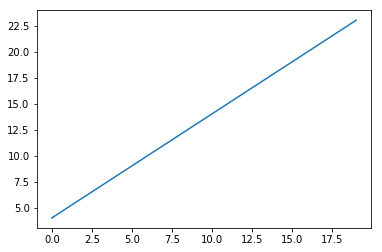

In [15]:
LVs = [float(x) for x in range(0,20)]
CCs = []
print(recep.rijbanen[0].MWV.value)
for LV in LVs:
    recep.conc_NOx_srm2.value = LV
    calc_Emiss(recep)
    calc_concs(recep)
    CCs.append(recep.Cb['NOx'])
import matplotlib.pyplot as plt
plt.plot(LVs,CCs)

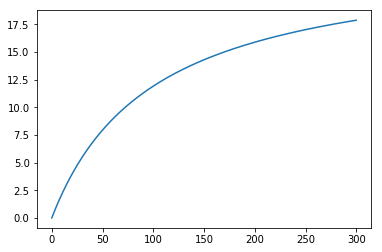

In [16]:
concs = [x/10. for x in range(3000)]
concs_no2 = []
for conc_tot_NO in concs:
       concs_no2.append(.6*recep.gcn['O3_HWN']*conc_tot_NO/(conc_tot_NO+100.))
    
plt.plot(concs,concs_no2)